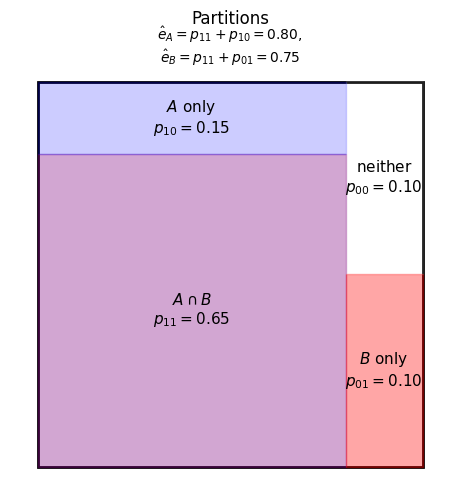

,A,B,w
0,0.0,0.0,2.063788
1,1.0,1.0,0.831663
2,0.0,0.0,0.617089
3,1.0,1.0,0.973315
4,1.0,1.0,1.103056
...,...,...,...
995,1.0,0.0,0.910398
996,1.0,1.0,0.872497
997,1.0,1.0,0.618283
998,0.0,1.0,0.666340


In [1]:
import numpy as np
import pandas as pd 
from tools import draw_rect_overlap
def make_toy_dataset(N=500, p11=0.65, p10=0.15, p01=0.10, p00=0.10, weight_scale=1.0, seed=42):
    """
    Create a toy dataset with correlated selections and weights.

    Returns
    -------
    arr : ndarray (N, 3)
        Columns: [A, B, w]
    """
    rng = np.random.default_rng(seed)

    # multinomial categories: 0=11, 1=10, 2=01, 3=00
    cats = rng.choice(4, size=N, p=[p11, p10, p01, p00])

    A = np.zeros(N, dtype=int)
    B = np.zeros(N, dtype=int)

    A[cats == 0] = 1
    B[cats == 0] = 1
    A[cats == 1] = 1
    B[cats == 2] = 1

    # mildly nontrivial weights
    # lognormal gives a realistic spread without going insane
    w = rng.lognormal(mean=0.0, sigma=0.4, size=N) * weight_scale

    arr = np.column_stack([A, B, w])
    return arr

p11, p10, p01, p00 = 0.65, 0.15, 0.10, 0.10
draw_rect_overlap(l=7, p11=p11, p10=p10, p01=p01, p00=p00,
                  title="Partitions")
arr = make_toy_dataset(N=1000, p11=p11, p10=p10, p01=p01, p00=p00, weight_scale=1.0, seed=1234)
df = pd.DataFrame(arr, columns=['A', 'B', 'w'])
df

## Check the Frequentist results

In [2]:
from tools import frequentist_weighted_mean_error
DeltaW, sigmaW = frequentist_weighted_mean_error(arr)
print(f"Frequentist weighted mean difference: DeltaW = {DeltaW:.4f} ± {sigmaW:.4f}")

Frequentist weighted mean difference: DeltaW = 0.0418 ± 0.0173


## Check the Bayesian Bootstrap results

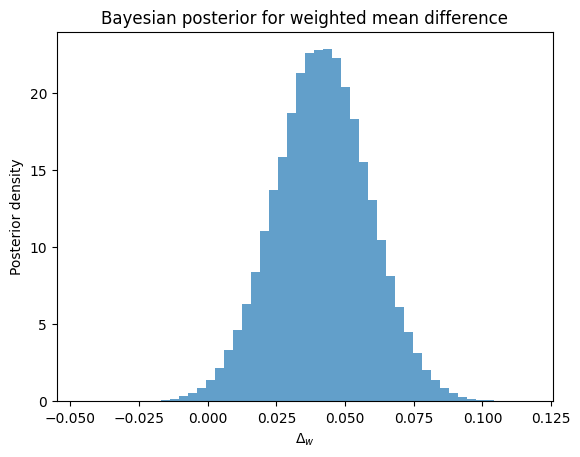

Bayesian weighted mean difference


,mean,std,median,Ppositive,ci68,ci95
Value,0.041702,0.017262,0.041661,0.992255,"[0.02455, 0.05885]","[0.00791, 0.07569]"


In [3]:
from tools import bayesian_weighted_mean_error 
import matplotlib.pyplot as plt

DeltaW_sample = bayesian_weighted_mean_error(arr, Npost=200000)

results = { "mean": DeltaW_sample.mean(),
        "std": DeltaW_sample.std(ddof=1),
        "median": np.median(DeltaW_sample),
        "Ppositive": np.mean(DeltaW_sample > 0),
        "ci68": np.percentile(DeltaW_sample, [16, 84]).round(5),
        "ci95": np.percentile(DeltaW_sample, [2.5, 97.5]).round(5),
    }

plt.hist(DeltaW_sample, bins=50, alpha=0.7, histtype="stepfilled" , density=True)
plt.xlabel(r"$\Delta_{w}$")
plt.ylabel("Posterior density")
plt.title("Bayesian posterior for weighted mean difference")
plt.show()
print(f"Bayesian weighted mean difference")
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Value']).T #reset_index()
df_results#



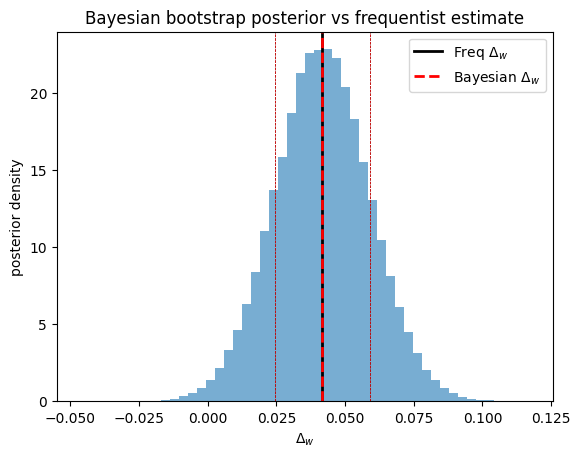

In [4]:
plt.hist(DeltaW_sample, bins=50, density=True, alpha=0.6)
plt.axvline(DeltaW, color="k", lw=2, label=r"Freq $\Delta_w$")
plt.axvline(DeltaW + sigmaW, color="k", ls="--" , linewidth=0.5)
plt.axvline(DeltaW - sigmaW, color="k", ls="--", linewidth=0.5)

plt.axvline(df_results["mean"].to_numpy(), color="red", lw=2, ls='--', label=r"Bayesian $\Delta_w$")
plt.axvline(df_results["mean"].to_numpy() + df_results["std"].to_numpy(), color="red", ls="--" , linewidth=0.5)
plt.axvline(df_results["mean"].to_numpy() - df_results["std"].to_numpy(), color="red", ls="--", linewidth=0.5)

plt.xlabel(r"$\Delta_w$")
plt.ylabel("posterior density")
plt.legend()
plt.title("Bayesian bootstrap posterior vs frequentist estimate")
plt.show()